In [ ]:
!pip install transformers
!git clone https://github.com/CompVis/taming-transformers
%cd taming-transformers

!mkdir -p logs/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p logs/vqgan_imagenet_f16_16384/configs
!wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt' 
!wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'logs/vqgan_imagenet_f16_16384/configs/model.yaml' 

%pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 einops>=0.3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 8.9 MB/s 
     |████████████████████████████████| 596 kB 45.4 MB/s 
     |████████████████████████████████| 6.6 MB 34.5 MB/s 
     |████████████████████████████████| 86 kB 1.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1335, done.
remote: Total 1335 (delta 0), reused 0 (delta 0), pack-reused 1335
Receiving objects: 100% (1335/1335), 409.77 MiB | 25.95 MiB/s, done.
Resolving deltas: 100% (278/278), done.
/content/taming-transformers
--2022-06-16 07:11:57--  https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206

In [ ]:
%cd taming-transformers
import sys
sys.path.append(".")

[Errno 2] No such file or directory: 'taming-transformers'
/content/taming-transformers


In [ ]:
import io
import os, sys
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

In [ ]:
# also disable grad to save memory
import torch
torch.set_grad_enabled(False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import yaml
import numpy as np
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel, GumbelVQ

import torch
import torch.nn as nn

from transformers import (
    AutoConfig,
    AutoTokenizer,
    BartForConditionalGeneration
)

def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config

def load_vqgan(config, ckpt_path=None, is_gumbel=False):
  if is_gumbel:
    model = GumbelVQ(**config.model.params)
  else:
    model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model.eval()

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def reconstruct_with_vqgan(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  z, _, [_, _, indices] = model.encode(x)
  print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
  xrec = model.decode(z)
  return xrec

config16384 = load_config("logs/vqgan_imagenet_f16_16384/configs/model.yaml", display=False)
vqgan = load_vqgan(config16384, ckpt_path="logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt")

tokenizer = AutoTokenizer.from_pretrained("/content/drive/Shareddrives/Molu/checkpoint-40000")
model = BartForConditionalGeneration.from_pretrained("/content/drive/Shareddrives/Molu/checkpoint-40000")

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

8.19kB [00:00, 378kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [ ]:
from tqdm.auto import tqdm

In [ ]:
vqgan = vqgan.to(device)

스케이트 보더가 시멘트 바닥에서 스케이트를 타고 있다.


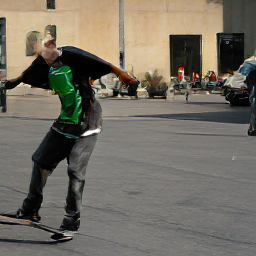

In [ ]:
input = {"labels": [3342, 5495, 10295, 11370, 14473, 6628, 11718, 7542, 11941, 6783, 2523, 14037, 11307, 3932, 2426, 9203, 4590, 9957, 9720, 9000, 2813, 2279, 11497, 1969, 11429, 12044, 381, 910, 13236, 12607, 11480, 4903, 2279, 7996, 1304, 6074, 5452, 7896, 432, 15366, 15798, 167, 5542, 142, 3846, 2061, 9656, 663, 2255, 3342, 11574, 15111, 6018, 10623, 6060, 6001, 4238, 910, 1702, 12861, 601, 7751, 2339, 1847, 12509, 8302, 13884, 15342, 5542, 7042, 7466, 4839, 15387, 3812, 15695, 7701, 11004, 652, 5031, 8276, 9103, 125, 9979, 15558, 11480, 13757, 7927, 14531, 1250, 689, 14494, 9010, 9103, 7020, 14547, 12557, 2428, 10845, 7900, 14899, 15631, 1765, 1402, 16314, 6783, 699, 10278, 572, 9206, 16274, 6018, 424, 5588, 3710, 2920, 9922, 6889, 16160, 9010, 14473, 15761, 4697, 3042, 8928, 16287, 9451, 7781, 10710, 6783, 6660, 9381, 2637, 11210, 10473, 15947, 12159, 11272, 6172, 6920, 10639, 6123, 3863, 3037, 825, 9325, 14176, 12139, 2339, 14185, 11904, 11456, 4815, 3168, 358, 6965, 6172, 4301, 15558, 13909, 16068, 10227, 11904, 3957, 8612, 5314, 8361, 10274, 1811, 663, 14164, 5666, 5693, 602, 4762, 15523, 2528, 15282, 15891, 9673, 2595, 6058, 11574, 358, 12187, 6920, 15963, 12623, 9325, 1052, 16226, 3710, 8322, 14037, 3210, 7466, 2439, 752, 10805, 3037, 13909, 4265, 14447, 11716, 3768, 1193, 1948, 15187, 9889, 8382, 3262, 15761, 15565, 7043, 7516, 6965, 5762, 11147, 6920, 7482, 6523, 5772, 11004, 11725, 1268, 4903, 5410, 14682, 6764, 11792, 8111, 14933, 9043, 13670, 9900, 1495, 7365, 5286, 14102, 5305, 6920, 15342, 81, 4099, 6524, 7977, 13670, 8493, 3932, 3851, 15331, 6172, 15575, 7771, 5305, 5885, 321], "input_ids": [21921, 14900, 14046, 9806, 8981, 14044, 27340, 18248, 14030, 21921, 22422, 16483, 15964]}

labels = torch.tensor(input["labels"]).to(device)
print(tokenizer.decode(input["input_ids"]))


q_t = vqgan.quantize.embedding(labels).reshape(1, 16, 16, 256).permute(0,3,1,2)
with torch.no_grad():
    img = vqgan.decode(q_t)
custom_to_pil(img[0])

In [ ]:
class KoDalle(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x, **kwargs):
        x = self.encoder.generate(x, **kwargs)[:, 1:-1]
        x = self.decoder.quantize.embedding(x).reshape(1, 16, 16, 256).permute(0,3,1,2)
        x = self.decoder.decode(x)
        return x


dalle = KoDalle(model, vqgan).to(device)

In [ ]:
promt = "바다 위의 흐린 하늘에서 나는 연들"

os.makedirs(f"/content/{promt}", exist_ok=True)

tokenized = tokenizer(promt, return_tensors="pt")
input_ids = tokenized.input_ids.to(device)

for idx in tqdm(range(128)):
    with torch.no_grad():
        img = dalle(
            input_ids,
            min_length=258,
            max_length=258,
            do_sample=True,
            temperature=1,
            top_k=512,
            no_repeat_ngram_size=3
        )

    img = custom_to_pil(img[0])
    img.save(f"/content/{promt}/{idx}.png", "png")

  0%|          | 0/128 [00:00<?, ?it/s]

In [ ]:
!nvidia-smi

Tue Jun 14 04:10:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    36W / 250W |   2181MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import json

with open("/content/drive/Shareddrives/Molu/data/train.json", "r", encoding="utf8") as f:
    lines = [json.loads(line)["input_ids"] for line in f.readlines()]

In [ ]:
for line in lines[:100]:
    print(tokenizer.decode(line))

한쌍의 기린이 울타리로 덮여 있는 나무에서 떨어져 있다.
거울, 싱크대, 변기가 있는 화장실
두 젊은 남자가 비디오 게임 컨트롤러를 들고 웃고 있다.
의자에 앉아 글을 쓰는 사람
창문 선반 위의 고양이가 창문 밖을 내다보고 있다.
눈이 쌓여 주차 미터기에 주차된 차량
다른 사람들이 나무 아래 앉아 있을 때 스케이트 보드를 타는 사람
어린 아이의 엉덩이에는 작은 고양이가 한마리 있어요.
학교 운동장에서 축구를 하는 10대 소녀
기린이 관중들의 손에서 먹이를 먹고 있다.
세마리의 소들과 개가 트럭 근처에 있다.
보도 위의 고양이가 건물 벽에 기대어 자전거를 바라보고 있다.
운동장에 있는 선수는 야구공을 던진다.
소나무에 텍스트를 넣어 액자에 넣어 둔 그림 문자.
문에 앵무새를 물고냉장고를 여는 남자
상자 안에 있는 매우 큰 피자
관중들이 지켜보는 테니스 코트의 테니스 선수들
가위가 고무줄로 매달려 있다
어린 소년이 테이블에 앉아 피자를 먹고 있다.
두마리의 프리스비가 보도 옆에 있는 아스팔트 도로에 누워 있다.
공원 벤치에 앉아 있는 두 여자, 한 여자가 그녀의 어깨 너머로 보고 있다.
테이블 위의 물로 채워진 깨끗한 꽃병에 장미 한송이
소년이 파란 색과 분홍색 연을 날리려고 한다.
식당 창문 앞에서 모자, 안경, 넥타이를 착용하고 마이크를 입에 대고 있는 사람.
연을 잡고 바다에서 보드를 타는 사람
화장실 변기와 부엌 싱크대
한 무리의 소년들이 야구 방망이를 들고 무릎을 꿇고 있다.
홈 플레이트의 타자, 포수, 심판
연을 가지고 함께 서 있는 사람들의 그룹.
서프 보드 두개를 들고 해변을 걷고 있는 한 남자.
유니폼을 입은 야구 선수가 배트를 휘두른다.
왼손에 노란 바나나를 들고 있는 남자
큰 미트볼과 치즈 샌드위치가 접시에 놓여 있다.
한쪽에 건물들이 있고 다른 쪽에 나무들이 있는 거리
밖에서 테니스 라켓을 든 남자 두명
녹색 반바지를 입고 수상 스키를 탄 남자
눈에 덮인 장치.
이를 닦는 동안 노래를 부르고 있는 남자.
도로 옆에 아직도 버스가 앉아 있다.
